
# IST664/CIS668 - Homework 5 Template

In recent classes, we've examined sequence-to-sequence (S2S) models that use recurrent networks to process sequences of character or word tokens. In this final homework, you will process the SQUAD V2 dataset, extracting the most brief among the Q/A pairs and process them with an S2S model to explore the limits of recurrence.

Most of this code has been borrowed from Labs 10 and 11. If you run into any problems, compare the code to what you used for the lab. 

Use this template to organize your code for Homework 5. Put your name and the names of your collaborators (if any) here:

Your name: Gughapriyaa Elango

Your collaborators: Sowmeya Maruthamuthu


*Task 1*: Install and process the SQUAD V2 dataset.


In [156]:
# Get the datasets package and load the data from HuggingFace

!pip install datasets # A package for creating a connection to HuggingFace data resources
from datasets import load_dataset

raw_dataset = load_dataset("squad_v2") # The names of the datasets can be obtained from the web-based discovery interface
raw_train_dataset = raw_dataset["train"] # We will use the training data first

type(raw_dataset), type(raw_train_dataset) # Display the types

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


  0%|          | 0/2 [00:00<?, ?it/s]

(datasets.dataset_dict.DatasetDict, datasets.arrow_dataset.Dataset)

In [157]:
# We will be using numpy, tensorflow, and keras
import numpy as np
import tensorflow as tf
from tensorflow import keras

tf.__version__

'2.12.0'

The MAX_INP and MAX_TARG variables below are key to the operation of this S2S model. We know from Class 10 that LSTMs have limits on how far a training gradient can go back through a long sequence of LSTM cells. The loop below filters the dataset to only include question and answer pairs that fit the maximum sequence lengths. Low values mean short LSTMs that are easy to train, but not much training data. 

Start the model using the  sequence length suggestions below and then gradually increase them to try to recover more training data from the dataset. You MUST try at least one additional gradation of these two values to get full credit for this lab. For example, you could raise MAX_INP to 50 and MAX_TARG to 30.

In [158]:
# Build a list of questions and answers plus character sets for each.
# Only include Q/A pairs where the message lengths fit within the
# maximums noted here:
MAX_INP = 50
MAX_TARG = 30

input_texts = []
target_texts = []
input_characters = set()
target_characters = set()

for entry in raw_train_dataset:
  # Some entries may not have an answer: Skip them
  if len(entry['answers']['text']) > 0:
    
    
    inp = entry['question'].strip()
    inp = inp.encode("ascii", "ignore")
    inp = inp.decode()
    
    targ = "\t" + entry['answers']['text'][0].strip() + "\n"
    targ = targ.encode("ascii","ignore")
    targ = targ.decode()

    if (len(inp) < MAX_INP) and (len(targ) < MAX_TARG):

      input_texts.append(inp)
      for char in inp:
          if char not in input_characters:
              input_characters.add(char)
    
      target_texts.append(targ)
      for char in targ:
          if char not in target_characters:
              target_characters.add(char)

len(input_texts), len(target_texts) # How much training data do we have

(24518, 24518)

<b>MAX_INP and MAX_TAR TRIED:</b> <br>
MAX_INP as 50 and MAX_TAR as 30 with batch size of 32, latent_dim of 256, running 100 epochs<br>
MAX_INP as 100 and MAX_TAR as 90 with batch size of 32, latent_dim of 256, running 50 epochs<br>
MAX_INP as 200 and MAX_TAR as 100 with batch size of 32, latent_dim of 256, running 50 epochs<br>
MAX_INP as 500 and MAX_TAR as 400 with batch size of 32, latent_dim of 256, running 50 epochs<br>
MAX_INP as 1000 and MAX_TAR as 800 with batch size of 32, latent_dim of 256, running 20 epochs<br>
Slowly I have increased the max length of the input and target sequence to run different iterations. But not all of them resulted in a generalizable model<br>
RESULTS OF EACH TRIAL IS RECORDED AT THE END

In [159]:
#
# Task 1a: Display the list of input characters
#
input_characters

{' ',
 '!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '+',
 ',',
 '-',
 '.',
 '/',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ':',
 ';',
 '=',
 '>',
 '?',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 '[',
 ']',
 '_',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z'}

In [160]:
#
# Task 1b: Display the list of target characters
#
target_characters

{'\t',
 '\n',
 ' ',
 '!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ':',
 ';',
 '=',
 '?',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 '[',
 ']',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 '~'}

In [161]:
#
# Task 1c: Display the lengths of the two character sets.
# Leave a comment explaining the difference in lengths of the two sets.
#
print("Length of input character sets",len(input_characters))
print("Length of target character sets",len(target_characters))

Length of input character sets 85
Length of target character sets 87


**Difference in the length of the two sets <br>**
The input character length is 75<br>
The output character lenght is 77<br>
The two additional characters are the vector representation of start and end token.<br>
We use "tab" \t as the "start sequence" character for the targets, and "\n" as "end sequence" character.<br>
Hence, we see the increase of two characters in the target character set.<br>
After changing the max_inp and max_tar, we get new characters and similarly, we see two characters increased in the target.

In [162]:
# Task 1d: Display the first 15 pairs of questions and answers
# 
[ (i, t) for i, t in enumerate(zip(input_texts[:15], target_texts[:15]))]

[(0, ('When did Beyonce start becoming popular?', '\tin the late 1990s\n')),
 (1, ('In what city and state did Beyonce  grow up?', '\tHouston, Texas\n')),
 (2, ('In which decade did Beyonce become famous?', '\tlate 1990s\n')),
 (3, ('In what R&B group was she the lead singer?', "\tDestiny's Child\n")),
 (4,
  ('What album made her a worldwide known artist?',
   '\tDangerously in Love\n')),
 (5, ("Who managed the Destiny's Child group?", '\tMathew Knowles\n')),
 (6, ('When did Beyonc rise to fame?', '\tlate 1990s\n')),
 (7, ("What role did Beyonc have in Destiny's Child?", '\tlead singer\n')),
 (8, ('When did Beyonc release Dangerously in Love?', '\t2003\n')),
 (9, ("What was Beyonc's role in Destiny's Child?", '\tlead singer\n')),
 (10,
  ("What was the name of Beyonc's first solo album?",
   '\tDangerously in Love\n')),
 (11, ('Which artist did Beyonce marry?', '\tJay Z\n')),
 (12, ("When did Destiny's Child end their group act?", '\tJune 2005\n')),
 (13, ("What was the name of Beyonc

In [163]:
# Colab instances do not have much memory. This code provides an upper
# bound on how many training instances we will try to process.
num_samples = min(20000, len(input_texts))
input_texts = input_texts[:num_samples]
target_texts = target_texts[:num_samples]

In [164]:
# Randomize the order of the texts
arr = np.arange(num_samples)
np.random.shuffle(arr)

input_texts = [input_texts[i] for i in arr]
target_texts = [target_texts[i] for i in arr]

In [165]:
# Task 1d: Display the first 15 pairs of questions and answers after randomization
# 
[ (i, t) for i, t in enumerate(zip(input_texts[:15], target_texts[:15]))]

[(0, ('Which Queen album was released in 1991?', '\tInnuendo\n')),
 (1,
  ("What was the name of Beyonc's first solo album?",
   '\tDangerously in Love\n')),
 (2, ('Beyonce signed a letter with who in 2015?', '\tthe ONE Campaign\n')),
 (3, ('Who won the 1880 general election?', '\tGladstone\n')),
 (4, ('In what year was Ma and Pa Kettle made?', '\t1949\n')),
 (5, ('What kind of elephant did the Ptolemies use?', '\tAfrican elephant\n')),
 (6, ('What event plaza is in Cary?', '\tKoka Booth Amphitheatre\n')),
 (7, ('What country has fair dealing laws?', '\tCanada\n')),
 (8, ('What religion is the Flying Fathers team?', '\tCatholic\n')),
 (9, ('A University discovered a primitive flying what?', '\tinsect\n')),
 (10, ('What were Spitfire Funds used for?', '\tto build fighters\n')),
 (11, ('The NES Max also did not feature what?', '\t"Slow" button\n')),
 (12, ("What was Aetius's career?", '\tdoxographer\n')),
 (13, ('Where is the Gold State Coach kept?', '\tthe Royal Mews\n')),
 (14,
  ('Whe

In [166]:
# This code creates tokens lists (of character tokens)
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)


In [167]:
# Task 1e: Display the number of unique input and output tokens.
# Add a comment explaining why the number of tokens is different.
#
print("Unique input tokens",input_characters)
print("Unique target tokens",target_characters)
print("Length of input tokens",num_encoder_tokens)
print("Length of target tokens",num_decoder_tokens)

Unique input tokens [' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '=', '>', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', ']', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Unique target tokens ['\t', '\n', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '=', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', ']', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '~']
Length of input tokens 85
Length of target tokens 87


**Difference in the length of the two token sets <br>**
Same as above, we have added \t and \n to the target characters <br>
The number of encoder tokens length is 75<br>
The number of decoder tokens length is 77<br>
The two additional characters are the vector representation of start and end token.<br>
We use "tab" \t as the "start sequence" character for the targets, and "\n" as "end sequence" character.<br>
Similarly, like the case above, changing the max_inp and max_target has resulted in 85 and two character increase in target as 87.


In [168]:
# This code defines "maximum message lengths" calibrated in the number of characters.
# Because we are doing a character-level model these values define how far
# the encoder LSTM and the decoder LSTM (respectively) need to be "unrolled"
# in order to do the training. 
#
# Also remember that shorter sequences will need to be padded.
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

Max sequence length for inputs: 49
Max sequence length for outputs: 29


In [169]:
# Task 1f: Display the max sequence length for the encoder and the decoder.
# Explain how these values came to be.
#
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

Max sequence length for inputs: 49
Max sequence length for outputs: 29


Maximum sequence lenght is how far the model will unroll<br>
This values came to be 29 and 19 because we had defined this in the beginning using MAX_INP as 30 and MAX_TARG as 20.<br>
Hence, maximum input of encoder sequence length comes as 29 and maximum target of decoder sequence length comes as 19. <br>
For the final iteration, the max_inp was set to 50 and max_tar was set to 30, hence we see 49 and 29. 

In [170]:
# Next we will vectorize all of the input and target messages

# First, make Python dictionaries for the input and target messages
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])


In [171]:
# Remember that the seq2seq data is actually a 3-tuple. The encoder takes 
# input messages as input but creates no output except for the hidden state.
# The decoder has both inputs and targets. These three lines fill vectors
# with zeroes to initialize them.

# The encoder inputs - will hold character sequences for short English phrases
encoder_input_data = np.zeros((len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float32")

# The decoder inputs - will hold character sequences for short French phrases
decoder_input_data = np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32")

# Same size numpy array for the decoder targets
decoder_target_data = np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype = "float32")

In [172]:
# Now fill the vectors

# Iterate over all of our phrase pairs
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    
    # Iterate over all of the characters in the input phrase
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0

    # This adds padding with spaces
    encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0

    # Iterate over all of the characters in the target phrase. Here we are
    # filling two vectors 
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    
    # This adds padding with spaces
    decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0
    decoder_target_data[i, t:, target_token_index[" "]] = 1.0

In [173]:
# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

In [174]:
# This is a daignostic to check our work from above.
# Task 1g: Add comments to each line of code in this block

#Empty string initialized
chars = ""

#iterating through the nested list of encoder_input_data[0] which is one-hot encoded
#iterating through rows
for i, iv in enumerate(encoder_input_data[1]):
  #iterating through columns
  for j, val in enumerate(iv):
    #check if the value of the one-hot encoding is 1
    if val == 1.0:
      #then reverse lookup the token index to decode sequence back to the input question
      #append word by word through the iteration
      chars += reverse_input_char_index[j]
#print the appended input question
print(chars)

What was the name of Beyonc's first solo album?  


In [175]:
# Task 1h: Create another block of code modeled on the above
# that translates one instance of decoder input data. 
#
chars2 = ""

for i, iv in enumerate(decoder_input_data[1]):
  for j, val in enumerate(iv):
    if val == 1.0:
      chars2 += reverse_input_char_index[j]
print(chars2)

 Fbohfspvtmz"jo"Npwf!""""""""


In [176]:
# Task 1i: Create another block of code modeled on the above
# that translates one instance of decoder target data. 
#
chars3 = ""

for i, iv in enumerate(decoder_target_data[1]):
  for j, val in enumerate(iv):
    if val == 1.0:
      chars3 += reverse_target_char_index[j]
print(chars3)

Dangerously in Love
         


In [177]:
# Task 1j: Display the lengths of the encoder input data, decoder input data
# and decoder target data. Explain the results in a comment.
len(encoder_input_data), len(decoder_input_data), len(decoder_target_data)


(20000, 20000, 20000)

In [178]:
len(encoder_input_data[1]), len(decoder_input_data[1]), len(decoder_target_data[1])

(49, 29, 29)

Length of encoder input data list, decoder input data list and decoder target data list are all 1879.<br>
If we recall, this is the length of our input_texts and target_texts that we have in the training data, that we got after preprocessing from the raw_train_dataset we imported.<br>
Each row of encoder input data contain 29 characters, as the maximum input sequence length was defined to 29. Along with existing characters, padding is added to the input sequences<br>
Similary, each row of decoder input data and decorder target data contain 19 characters as the maximum target sequence was set to 19. Along with existing characters, padding is added to the target sequence.

<b>Final iteration changing max_inp and max_tar</b><br>
Since the final length of lists were capped to 20000, we see all the length of the encoder input data, decoder input data and decoder target data to be 20000. 

*Task 2*: Build a sequence to sequence LSTM model to train.

In [179]:
# Example hyperparameters to use for training the model: Tweak these to improve
# model performance. What does changing the batch_size do? Should the latent
# dimension of the "thought vector" be larger or smaller?

batch_size = 32  # Batch size for training.

latent_dim = 256  # Latent dimensionality of the thought vector encoding space.


<b>Hyperparameter Tuning</b><br>
<b>Batch size:</b><br>
Changing batch size changes the number of epochs and determines how quickly the model fits. With 80,000 training examples, a batch size of 32 would result in 2,500 batches per epoch, while a batch size of 128 would result in 625 batches per epoch.<br>
Larger batch size, tend to make better use of parallelism and can lead to faster training times, but they may also require more memory and computational resources.<br>
<b>Playing with batch size:</b><br>
Increasing the batch size to 64 and epochs as 50, with 256 latent # dimensions, we see 61% validation_categorical_accuracy in the first epoch. By the 12th epoch, we see the model reaches 69% accuracy.<br>
Increasing the batch size to 128 and epochs as 50, with 256 latent # dimensions, we see 62% validation_categorical_accuracy in the second epoch. By the 20th epoch, we see the model reaches 69% accuracy.<br>
<b>Final iteration:</b>For the final iteration with size of 20000 training examples, i used batch size of 32, as that is most appropriate to manage the number of epochs and training time, along with accuracy.<br>
<b>Latent dimension of thought vector:</b><br>
In general, a larger number of dimensions in the latent "thought vector" can capture more complex and nuanced relationships between the input and output sequences, resulting in better performance on more challenging tasks. However, a larger number of dimensions also requires more computational resources and may lead to overfitting if not properly regularized.<br>
<b>Playing with latent # dimensions:</b><br>
With increased training sample size, reducing the latent # dimensions to 128, and batch size of 32, running 50 epochs, we see validation categorical accuracy at 1st epoch is 61% which rises well above 70% by 20th epoch. We see that in this training, the model is underfitting with smaller latent # dimensions.<br>
I find that, reducing the latent # dimensions works well when balancing accuracy and overfitting. Increasing the latent # dimensions above 256 can lead to overfitting in the training and lesser validation accuracy. In the case of increasing latent # dimensions above 256, we can consider regularization techniques like adding dropout layer.<br>
<b>Final iteration:</b>For the final iteration with size of 20000 training examples, i used latent # dimensions as 256, as this was giving the right training without overfitting or underfitting.<br>

In [180]:
# 1. Define an input sequence and process it.
encoder_inputs = keras.Input(shape=(None, num_encoder_tokens))

# 2. Use a LSTM layer to process the input vectors. After today's lecture
# you should know what return_state does.
encoder = keras.layers.LSTM(latent_dim, return_state=True)

# 3. Save the output from the encoder, but see step 4. Note the use of 
# the functional programming interface here. For deep learning models that
# are not simple seqiential layers, this interface provides a stratightforward
# way of connecting one element of a model to the element that it should 
# feed into.
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# 4. We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

In [181]:
# Set up the decoder, using `encoder_states` as initial state.

# This takes the target tokens as the input.
decoder_inputs = keras.Input(shape=(None, num_decoder_tokens))

# The LSTM later has the same internal dimensionality as for the encoder.
decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)

# Save the decoder output: Note that this uses decoder_inputs
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)

# Dense with softmax allows us to predict categorical output (our list of French characters)
decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax")

# Output layer
decoder_outputs = decoder_dense(decoder_outputs)

# Define the overall model. This binds the encoder and decoder and will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [182]:
# We use categorical_crossentropy because our prediction is multinomial: we
# are trying to predict which is the most likely character for the next time step.
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["categorical_accuracy"])


In [183]:
# Task 2a: Display a model summary using the appropriate method.
# Add a comment describing the number of trainable gates and how 
# this might compare to a CNN model.
#
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, None, 85)]   0           []                               
                                                                                                  
 input_14 (InputLayer)          [(None, None, 87)]   0           []                               
                                                                                                  
 lstm_6 (LSTM)                  [(None, 256),        350208      ['input_13[0][0]']               
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                            

**Number of trainable gates:<br>**
We can see that the number of trainable gates is 701,773, i.e, all the total parameters are trainable.<br>
**Comparing to a CNN model:<br>**
For this Sequence to Sequence model using LSTM, we are using a functional model, as opposed to the sequential modeling used in CNN architecture. With this functional interface, we can connect layers in a different way, instead of just adding layer after layer. Apart from architectural differences, we see a difference in the number of trainable parameters.<br>

The sequence to sequence model significantly has more trainable parameters than CNN. This model uses an encoder network and decoder network along with LSTM layers, which contains large number of parameters.<br>

Inversely in CNN, they contain convolutional layers followed by fully connected layers.They could possess a large number of filters, but the number of trainable parameters is low in CNN.

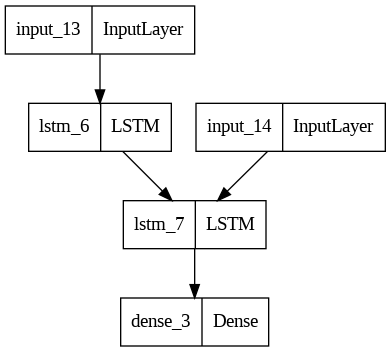

In [184]:
# Task 2b: Display a plot of the model's shape using the appropriate method.
# Add a comment pointing out how and where the 3-tuple data are used in the model.

keras.utils.plot_model(model)

<b>Architecture:</b>
We have a LSTM layer that acts as bridge between two input layers and the dense layer.This receives input from both - thought vector(hidden and cell state of first LSTM) as well as decoder input data (which contains start and end token)<br>
<br>
There is the triplet of data here : Input to encoder, input to decoder and output of decoder.<br>

*Task 3*: Train the model, paying close attention to training time and the progress of validation loss and validation accuracy. Given the basic model hyperparameters used in the template together with the small amount of data this model trains very fast. You may need to raise the number of epochs or lower the batch size or both to try to improve the model accuracy.

In [142]:
# Train the model: Choose a value for epochs to balance training time and accuracy
#MAX_INP OF 100 AND MAX_TAR OF 90
#Batch size - 32, latent dim - 256
epochs = 50  # Number of epochs to train for. You may need to raise this after seeing initial results.

history = model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
)

# You should be looking for a val_categorical_accuracy in excess of 0.60.

Epoch 1/50
500/500 [==============================] - 21s 30ms/step - loss: 0.6542 - categorical_accuracy: 0.8471 - val_loss: 0.5121 - val_categorical_accuracy: 0.8612
Epoch 2/50
500/500 [==============================] - 9s 17ms/step - loss: 0.5051 - categorical_accuracy: 0.8623 - val_loss: 0.4781 - val_categorical_accuracy: 0.8656
Epoch 3/50
500/500 [==============================] - 7s 15ms/step - loss: 0.4585 - categorical_accuracy: 0.8698 - val_loss: 0.4509 - val_categorical_accuracy: 0.8711
Epoch 4/50
500/500 [==============================] - 8s 15ms/step - loss: 0.4416 - categorical_accuracy: 0.8737 - val_loss: 0.4386 - val_categorical_accuracy: 0.8745
Epoch 5/50
500/500 [==============================] - 8s 16ms/step - loss: 0.4294 - categorical_accuracy: 0.8766 - val_loss: 0.4282 - val_categorical_accuracy: 0.8766
Epoch 6/50
500/500 [==============================] - 8s 15ms/step - loss: 0.4184 - categorical_accuracy: 0.8794 - val_loss: 0.4182 - val_categorical_accuracy: 0.87

<b>Trials done with training</b><br>
<b>Trial 1</b><br>
MAX_INP OF 100 AND MAX_TAR OF 90<br>
Batch size - 32, latent dim - 256<br>
We see that validation_accuracy has reached upto 90%. However, testing this model in comparing the cosine similarity, we see that the vectors are the same, and the model has not been trained properly.



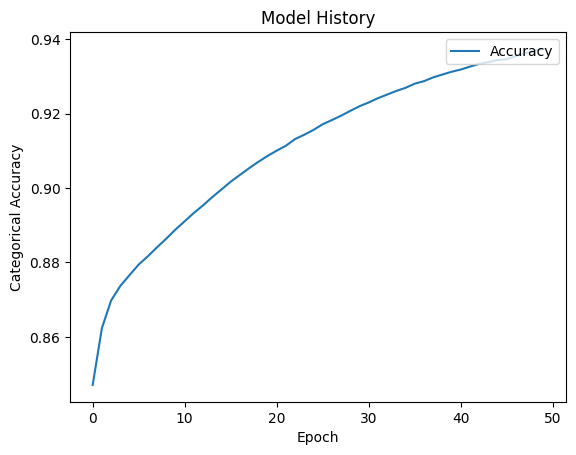

In [143]:
# Graphing code fragment modified from Rahul Verma on Stackoverflow
from matplotlib import pyplot as plt

plt.plot(history.history['categorical_accuracy'])
plt.title('Model History')
plt.ylabel('Categorical Accuracy')
plt.xlabel('Epoch')
plt.legend(['Accuracy'], loc='upper right')
plt.show()

<b>Other trials</b><br>
Many trials were run by changing the training sample sizes, batch size to 32,64,128 and latent # size to 128, 256.<br>
Eventhough with increasing training examples, the model gained more validation accuracy, the cosine similarity were the same for the two thought vector tests. Also, the final mean of cosine similarity was around 2.5.<br>
Hence, higher accuracy was traded for better cosine similarity in this final iteration:

In [185]:
# Train the model: Choose a value for epochs to balance training time and accuracy
#MAX_INP - 50, MAX_TAR - 30
#Batch size - 32, latent dim - 256
epochs = 100  # Number of epochs to train for. You may need to raise this after seeing initial results.

history = model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
)

# You should be looking for a val_categorical_accuracy in excess of 0.60.

Epoch 1/100
500/500 [==============================] - 12s 14ms/step - loss: 1.4991 - categorical_accuracy: 0.6216 - val_loss: 1.2381 - val_categorical_accuracy: 0.6556
Epoch 2/100
500/500 [==============================] - 4s 8ms/step - loss: 1.1977 - categorical_accuracy: 0.6616 - val_loss: 1.1555 - val_categorical_accuracy: 0.6690
Epoch 3/100
500/500 [==============================] - 4s 8ms/step - loss: 1.1407 - categorical_accuracy: 0.6732 - val_loss: 1.1217 - val_categorical_accuracy: 0.6777
Epoch 4/100
500/500 [==============================] - 5s 11ms/step - loss: 1.1048 - categorical_accuracy: 0.6820 - val_loss: 1.0870 - val_categorical_accuracy: 0.6869
Epoch 5/100
500/500 [==============================] - 4s 9ms/step - loss: 1.0740 - categorical_accuracy: 0.6899 - val_loss: 1.0631 - val_categorical_accuracy: 0.6940
Epoch 6/100
500/500 [==============================] - 4s 9ms/step - loss: 1.0484 - categorical_accuracy: 0.6967 - val_loss: 1.0406 - val_categorical_accuracy: 0.

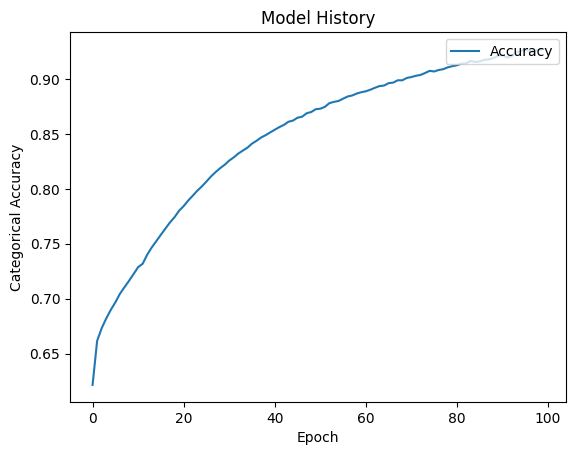

In [186]:
# Graphing code fragment modified from Rahul Verma on Stackoverflow
from matplotlib import pyplot as plt

plt.plot(history.history['categorical_accuracy'])
plt.title('Model History')
plt.ylabel('Categorical Accuracy')
plt.xlabel('Epoch')
plt.legend(['Accuracy'], loc='upper right')
plt.show()

<b>Final Iteration:</b><br>
MAX_INP - 50, MAX_TAR - 30<br>
Batch size - 32, latent dim - 256<br>
epochs = 100<br>
Tuning to these parameters, about 72% validation accuracy is reached.<br>


####Task 3: Add a comment about training success
<b>Training Success:</b><br>
After trying final iteration, we see that: <br>
We can see in the graph that after about 80 epochs, the accuracy line overfits to the training sample.<br>
After this point, additional improvement in accuracy can be reached, however that high accuracy does not provide the corresponding cosine similarity values.<br>
Just the validation categorical accuracy is not enough to test if the model is good enough. The checking of the two thought vectors to see how the model generalizes is very important.<br>
Replace this text with a comment  that describes what you see in the model history graph and the model training diagnostics. Have you reached the point in the training where not much additional improvement can be achieved? How do you know? Is the validation categorical accuracy sufficient?

## Task 4: Use the trained model for inference

The basic inference functions from Lab 11 are included here. 

Note: Add a code timer to the appropriate code to find out how long it takes to run inference. 

In [187]:
import time
start_time = time.time()

# Construct the encoder and decoder

# Here's the encoder
encoder_inputs = model.input[0]  # Encoder input layer
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output  # Encoder model LSTM

# This is the "thought vector" the hidden state that is used to start the decoder
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(encoder_inputs, encoder_states)

# This is the decoder, starting with the input layer 
decoder_inputs = model.input[1]  
decoder_state_input_h = keras.Input(shape=(latent_dim,))
decoder_state_input_c = keras.Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_lstm = model.layers[3] # Decoder model LSTM 

decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec, state_c_dec]

decoder_dense = model.layers[4] # Dense output layer

decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)
end_time = time.time()
elapsed_time = end_time - start_time

print("Elapsed time: ", elapsed_time, "seconds")

Elapsed time:  0.42430615425109863 seconds


In order to run inference, the model takes about 0.42 seconds.

In [188]:
# Task 4a: Summarize the encoder model with the appropriate method.
#
encoder_model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, None, 85)]        0         
                                                                 
 lstm_6 (LSTM)               [(None, 256),             350208    
                              (None, 256),                       
                              (None, 256)]                       
                                                                 
Total params: 350,208
Trainable params: 350,208
Non-trainable params: 0
_________________________________________________________________


In [189]:
# Task 4b: Summarize the decoder model with the appropriate method.
#
decoder_model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, None, 87)]   0           []                               
                                                                                                  
 input_15 (InputLayer)          [(None, 256)]        0           []                               
                                                                                                  
 input_16 (InputLayer)          [(None, 256)]        0           []                               
                                                                                                  
 lstm_7 (LSTM)                  [(None, None, 256),  352256      ['input_14[0][0]',               
                                 (None, 256),                     'input_15[0][0]',        

####Task 4c: Add a comment explaining the encoder and decoder models

Replace this text with a comment that describes what you see above in the model summaries. Comment on the number of trainable gates and how this corresponds to the size of the original model we trained. Based on the model builder just above, describe how the internal cell states are managed for the decoder and encoder. Make sure you use the correct terminology when referring to each of the two internal cell states.

In these next three blocks, we have code to test whether our encoder is properly trained.

**Encoder model:**<br>
350,208 trainable parameters
The input sequence is fed into the encoder one token at a time, and the encoder calculates the hidden state and cell state at each time step using a set of weights and biases. <br>
**Decoder model:**<br>
374,615 trainable parameters<br>
The internal cell states are initialized using the final hidden and cell states of the encoder. The decoder then generates the output sequence one token at a time, using the current hidden state and cell state to predict the next token in the sequence. At each time step, the cell state is updated using the same set of gates as in the encoder, but the input to the gates is a combination of the decoder's hidden state and the output from the previous time step.<br>
We see that the total trainable parameters in the orginal model 724,823 is a sum of the parameters from encoder and decoder models together. 
<br> This are almost
Looks like three sources of input, but really only two.
The first is the decoder input data: start and end tokens
The latter two are the h and C - hidden and cell state components of the thought vector.

In [214]:
# Make one prediction using the first data instance
states_value = encoder_model.predict(encoder_input_data[0 :  1])

states_value[0].shape, states_value[1].shape

1/1 [==============================] - 0s 40ms/step


((1, 256), (1, 256))

In [215]:
# Make one prediction using the second data instance
states_value1 = encoder_model.predict(encoder_input_data[1 :  2])

states_value1[0].shape, states_value1[1].shape

1/1 [==============================] - 0s 28ms/step


((1, 256), (1, 256))

In [216]:
# We now have two instances of thought vectors, with states_value
# based on doing a prediction using the FIRST instance from the input
# data and the states_value1 based on doing a prediction using the SECOND 
# instance from the input data. Because these two pieces of input data
# are very different, they should produce very different thought vectors.
# If the resulting thought vectors are similar or identical, this indicates that
# the encoder model is not properly trained.

# Task 4d: Write a few lines of code to compare the two thought vectors. 
# Confirm whether they are notably different from one another. If they are 
# too similar, the model tests below will tend to generate the same answers
# for many questions.
#
from sklearn.metrics.pairwise import cosine_similarity
cell_cos_sim = cosine_similarity(states_value[0], states_value1[0])
print("Cell state cosine similarity",cell_cos_sim)


Cell state cosine similarity [[0.20670769]]


Task 4d, just above, is critical for diagnosing whether the encoder stage of the model is sufficiently trained. If the two thought vectors are too similar, then the encoder has not trained properly. Go back and make adjustments to the model hyperparameters to improve the training.

Add a comment in this text block documenting where you ended up.

**To check if the encoder is underfitting:**<br>
In sequence to sequence model, encoder model.predict gives the final state of the encoder network. The resulting 2 tuple numpy array gives the two states.<br>
states_value[0] gives the final cell state and states_value[1] gives the final hidden state.<br>
Both cell state and hidden state can be used in finding cosine similarity.<br>
<b>Comparing cell state cosine similarity:</b><br>
0.206<br>
This indicates very low cosine similarity between the thought vectors, indicating that the model has trained properly.


In [193]:
# Here's a function to decode sequences. This takes a one-hot encoded 
# input sequence as the input. It runs the encoder model with that input to
# generate the "thought vector." The thought vector is fed to the decoder
# model and a \t is issued to the decoder to start producing a sequence.

def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate an empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index["\t"]] = 1.0

    # Sampling loop for a batch of sequences
    stop_condition = False
    decoded_sentence = ""
    
    # Always a little risky to use a while loop, but we don't know what 
    # length of sentence the decoder will issue - that's pretty much the 
    # whole point of a sequence-to-sequence model, right?
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value, verbose=False)

        # Sample a token: Find the index of the most probable output character
        sampled_token_index = np.argmax(output_tokens[0, -1, :])

        # Use our reversing dictionary to decode the predicted character
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length of a decoder output sequence
        # or find that the decoder has issued a stop character.
        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))

        # This one-hot encodes the current character to use as input for the next iteration
        target_seq[0, 0, sampled_token_index] = 1.0

        # Update states
        states_value = [h, c]
    
    return decoded_sentence


In [194]:
# The range() call controls how many input sequences we will test. 
# Task 4e: Change to review at least 10 decoded sequences

#Change the range
for seq_index in range(10):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index : seq_index + 1]

    # Here's where we call our custom function
    decoded_sentence = decode_sequence(input_seq)

    print("Input sentence:", input_texts[seq_index], "Decoded sentence:", decoded_sentence)

1/1 [==============================] - 0s 32ms/step
Input sentence: Which Queen album was released in 1991? Decoded sentence: Melbourne

1/1 [==============================] - 0s 26ms/step
Input sentence: What was the name of Beyonc's first solo album? Decoded sentence: Britain

1/1 [==============================] - 0s 30ms/step
Input sentence: Beyonce signed a letter with who in 2015? Decoded sentence: the ONE Campaign

1/1 [==============================] - 0s 18ms/step
Input sentence: Who won the 1880 general election? Decoded sentence: Marshall Grad

1/1 [==============================] - 0s 19ms/step
Input sentence: In what year was Ma and Pa Kettle made? Decoded sentence: 1949

1/1 [==============================] - 0s 20ms/step
Input sentence: What kind of elephant did the Ptolemies use? Decoded sentence: The lame uncill, News

1/1 [==============================] - 0s 17ms/step
Input sentence: What event plaza is in Cary? Decoded sentence: Alexander Grazada

1/1 [=============

In [195]:
# Here's a function that put's one more layer of convenience on top of
# decode_sequences. This function takes plain text as input and converts
# it to the one hot encoding needed to get the prediction model to work.

def answer(text_2):
  text_2 = text_2.replace("\n","")
  if len(text_2) <= max_encoder_seq_length:
    # Fill up a single one-hot encodign vector with zeroes
    my_input_data =  np.zeros((1, max_encoder_seq_length, num_encoder_tokens), dtype="float32")

    # Iterate over all of the characters in the input phrase
    for t, char in enumerate(text_2):
      my_input_data[0, t, input_token_index[char]] = 1.0

    # This adds padding with spaces
    my_input_data[0, t + 1 :, input_token_index[" "]] = 1.0
    translated_sentence = decode_sequence(my_input_data)
    print (text_2, " ", translated_sentence)
    return translated_sentence

  else:
    print("Input phrase is longer than the maximum encoder sequence length.")


In [219]:
# Task 4f: Test the answer() function with at least two different examples
# of short questions. Make sure not to exceed the maximum encoder sequence length.
#
 
example1 = answer("What kind of elephant did the Ptolemies use?")


1/1 [==============================] - 0s 28ms/step
What kind of elephant did the Ptolemies use?   The lame uncill, News



In [220]:
example2 = answer("A University discovered a primitive flying what?")


1/1 [==============================] - 0s 30ms/step
A University discovered a primitive flying what?   insect



*Task 5*: In this final task we are going to use the validation data from SQUAD V2 to make some predictions and compare what the model produces to what the real answers are in the validation data.

In [198]:
# This is similar to the code at the top of the notebook.
raw_test_dataset = raw_dataset["validation"] # We will use the validation data now

type(raw_dataset), type(raw_test_dataset) # Display the types

(datasets.dataset_dict.DatasetDict, datasets.arrow_dataset.Dataset)

In [199]:
# Task 5a: Display how much data is in the raw_test_dataset
#
len(raw_test_dataset)

11873

In [200]:
# This is similar to the code at the top of the notebook. We're going to make
# the assumption, based on reusing the same ASCII conversion as before, that
# the character sets produced in these questions and answers will be the same
# as the ones our model was set up to handle.
 
# Build a list of questions and answers plus character sets for each test instance
test_input_texts = []
test_target_texts = []

for entry in raw_test_dataset:
  # Some entries may not have an answer: Skip them
  if len(entry['answers']['text']) > 0:
    
    inp = entry['question'].strip()
    inp = inp.encode("ascii", "ignore")
    inp = inp.decode()
    
    targ = "\t" + entry['answers']['text'][0].strip() + "\n"
    targ = targ.encode("ascii","ignore")
    targ = targ.decode()

    # Remember that we can only use short questions and answers, same as
    # the original model
    if (len(inp) < MAX_INP) and (len(targ) < MAX_TARG):
      test_input_texts.append(inp)
      test_target_texts.append(targ)



In [201]:
# Task 5b: Display how much data is in test_input_texts and test_target_texts
#
print("Length of test_input_texts",len(test_input_texts))
print("Length of test_target_texts",len(test_target_texts))

Length of test_input_texts 1384
Length of test_target_texts 1384


In [202]:
# Task 5c: Display the first 15 question/answer pairs
#
[ (i, t) for i, t in enumerate(zip(test_input_texts[:15], test_target_texts[:15]))]

[(0, ('In what country is Normandy located?', '\tFrance\n')),
 (1, ('When were the Normans in Normandy?', '\t10th and 11th centuries\n')),
 (2,
  ('From which countries did the Norse originate?',
   '\tDenmark, Iceland and Norway\n')),
 (3, ('Who was the Norse leader?', '\tRollo\n')),
 (4,
  ('Who was the duke in the battle of Hastings?',
   '\tWilliam the Conqueror\n')),
 (5, ('Who ruled the duchy of Normandy', '\tRichard I\n')),
 (6, ('What religion were the Normans', '\tCatholic\n')),
 (7, ('What is the original meaning of the word Norman?', '\tViking\n')),
 (8, ('When was the Duchy of Normandy founded?', '\t911\n')),
 (9, ('What river originally bounded the Duchy', '\tSeine\n')),
 (10, ('What was the Norman religion?', '\tCatholicism\n')),
 (11, ('What part of France were the Normans located?', '\tnorth\n')),
 (12,
  ("What was one of the Norman's major exports?", '\tfighting horsemen\n')),
 (13, ('When did Herve serve as a Byzantine general?', '\t1050s\n')),
 (14, ('When did Rober

In [224]:
# Task 5d: Display one model prediction generated by answer() and compare that
# to the actual, correct response in test_target_texts
#
test_example = answer("What river originally bounded the Duchy") 

1/1 [==============================] - 0s 18ms/step
What river originally bounded the Duchy   the carrett



The model is making a wrong prediction for the question:
What river originally bounded the Duchy
The answer is Seiene
The predicted answer is the carrett

To complete task 5 you will need to generate cosine similarities between the predictions created by answer() and the actual, correct responses in test_target_texts. We'll use a sentence summarizer to do the job.

In [204]:
!pip install sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [205]:
# Now load a pre-trained sentence transformer. There are hundreds to choose from.
# This downloads a lot of data to your virtual machine and takes half a minute or so.
from sentence_transformers import SentenceTransformer

sent_model = SentenceTransformer('distiluse-base-multilingual-cased-v2')
# Why is it sometimes a good idea to use a multilingual model?

In [210]:
# Now evaluate all of the text items in a loop generating a list of cosine similarities
from sklearn.metrics.pairwise import cosine_similarity
cos_sim_list = []

for test_text, correct_answer in zip(test_input_texts, test_target_texts):
  a = sent_model.encode([answer(test_text)])
  b = sent_model.encode([correct_answer])
  cos_sim_list.append(cosine_similarity(a, b))

1/1 [==============================] - 0s 41ms/step
In what country is Normandy located?   Berkeleye Sausor

1/1 [==============================] - 0s 20ms/step
When were the Normans in Normandy?   the late 1990s

1/1 [==============================] - 0s 22ms/step
From which countries did the Norse originate?   Greek

1/1 [==============================] - 0s 23ms/step
Who was the Norse leader?   Alexander Glazunov.

1/1 [==============================] - 0s 18ms/step
Who was the duke in the battle of Hastings?   Martin Landas

1/1 [==============================] - 0s 19ms/step
Who ruled the duchy of Normandy   Martin Heinrish

1/1 [==============================] - 0s 17ms/step
What religion were the Normans   Catalonia

1/1 [==============================] - 0s 21ms/step
What is the original meaning of the word Norman?   ParS Amakogdines

1/1 [==============================] - 0s 29ms/step
When was the Duchy of Normandy founded?   March 14

1/1 [==============================] - 0s

In [211]:
# Task 5e: Display some of cos_sim_list and say why the values make sense.
#
cos_sim_list[0:15]

[array([[0.21660203]], dtype=float32),
 array([[0.47211456]], dtype=float32),
 array([[0.2217663]], dtype=float32),
 array([[0.06844139]], dtype=float32),
 array([[0.23908253]], dtype=float32),
 array([[0.27418196]], dtype=float32),
 array([[0.5101071]], dtype=float32),
 array([[0.29558247]], dtype=float32),
 array([[0.27850497]], dtype=float32),
 array([[0.547591]], dtype=float32),
 array([[0.36747032]], dtype=float32),
 array([[0.89819825]], dtype=float32),
 array([[0.18786253]], dtype=float32),
 array([[0.6843851]], dtype=float32),
 array([[0.29077107]], dtype=float32)]

The cosine similarity values range very low from 0.1 to pretty high as 0.89. With a accuracy score of 72%, we can expect to see misclassifications as well as right classifications. Hence the cosine similarity values make sense.

<b>Cosine similarity values:</b><br>


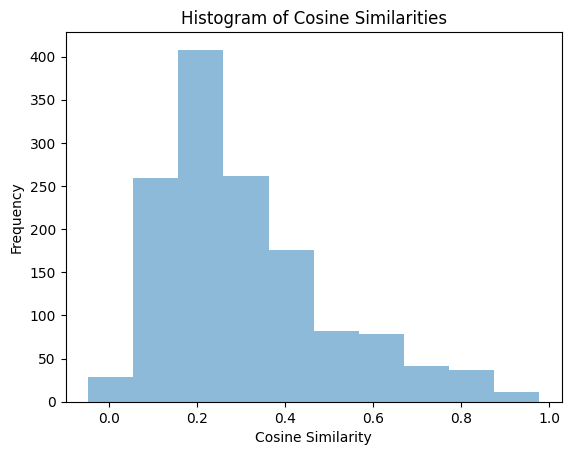

In [212]:
# Task 5f: Plot a histogram of the values in cos_sim_list
#
import matplotlib.pyplot as plt
plt.hist([a.tolist()[0][0] for a in cos_sim_list], alpha=0.5)
plt.title("Histogram of Cosine Similarities")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.show()

In [213]:
# Task 5g: Show the mean cosine similarity of the values in cos_sim_list. The
# basic code template generates a mean cosine similarity of about 0.35. Your
# job in adjusting the model training data and hyperparameters is to  
# beat this value.
#
print("Mean",np.mean(cos_sim_list))
print("Max",np.max(cos_sim_list))

Mean 0.3086667
Max 0.97690296


Even after tuning hyperparameters in many combinations, training a model with higher accuracy and ensuring the thought vector test is passed, the resulting best cosine similarity lies around 0.3-0.35. It has not exceeded 0.35.

##Concluding Comments

Replace this text with answers to the following questions based on your exploration of model and data parameters.

1. What's the upper limit of sequence length for encoder and decoder models that still produces a trainable model.<br>
MAX_INP as 50 and MAX_TAR as 30 with batch size of 32, latent_dim of 256, running 100 epochs :
validation categorical accuracy reaches 70% in the 7th epoch and by 50th epoch 75% accuracy is reached, after which the model is overfitting.<br>
Mean cosine similarity : 0.31<br>
MAX_INP as 100 and MAX_TAR as 90 with batch size of 32, latent_dim of 256, running 50 epochs :
validation categorical accuracy reaches 84.3% in the 1st epoch and by 20th epoch 89% accuracy is reached, after which the model is overfitting.<br>
MAX_INP as 200 and MAX_TAR as 100 with batch size of 32, latent_dim of 256, running 50 epochs :
validation categorical accuracy reaches 87.8% in the 1st epoch and by 10th epoch 89% accuracy is reached, after which the model is overfitting.<br>
MAX_INP as 500 and MAX_TAR as 400 with batch size of 32, latent_dim of 256, running 50 epochs :
ERROR OF NOT ENOUGH RAM<br>
Your session crashed after using all available RAM. If you are interested in access to high-RAM runtimes, you may want to check out Colab Pro.<br>
MAX_INP as 1000 and MAX_TAR as 800 with batch size of 32, latent_dim of 256, running 20 epochs :
ERROR OF NOT ENOUGH RAM<br>
Your session crashed after using all available RAM. If you are interested in access to high-RAM runtimes, you may want to check out Colab Pro.<br>
Hence, the maximum extent due to computation powers is upto MAX_INP - 200 and MAX_TAR - 100.<br>
To produce a trainable model, with the right cosine similarity check, moving beyond MAX_INP of 60 and MAX_TAR of 50 are providing similar cosine for the two thought vectors.<br>

2. Why can't you properly train a sequence to sequence model with longer sequences?<br>
We are not able to properly train a sequence above a certain limit of sequences is because the model cannot handle longer dependencies. It faces the problem of vanishing and exploding gradients. After few iterations, it cannot remember the previous states.<br>

3. Given the best model that you were able to train, is the model producing sensible answers? Why or why not?<br>
In few instances, it does provide contextually right answers, though it not accurate. We cannot completely say that the model is not learning, but it still has to perform better to handle longer dependencies and answer accurately.<br> 

4. What are one or two of the main challenges involved in working with a question and answer dataset like SQUAD V2?<br>
The model has a difficult time understanding the context of the questions in SQUAD v2 dataset. This creates ambiguity for the model and ends up in misclassifications.<br>

5. Based on everything you have learned in the class, does it seem like a sequence to sequence model is the best approach to question answering? If you answered "no", then mention one or two other models that you think would perform better.<br>
Sequence to sequence can perform question answering tasks, but they are definitely not the best. In order to perform better, we can use more advanced transformer based models like BERT and use attention mechanisms to selectively provide weights to the input. This can help remember important information over long dependencies. 
